
### US ECO MODEL: SAHM RULE (For educational/illustrative purposes only)

- **Model:**
	- Eco/Price Momentum combo
    - Use the Sahm-rule to define a recession. Using relative price momentum on financial assets.
- **Trading frequency:** monthly
- **Time Period studied:** 1960 - now
- **Data:**
    - S&P500 index:from Yahoo finance
    - Tbill-yield: from Yahoo finance
    - Treasury yield:  from NasdaqLink/Quandl
    - Unemployment rate: from Fred
- **Simple rules:**
    - Sahm-Rule: US Recession starts if U3 is 0.5% larger than the 12-month low in U3.
    - If no recession: invest in S&P500
    - If recession:switch in momentum-modus:
    	- Invest in the asset class (S&P500, Treasuries or Tbills) with the best composite momentum score. 
 - **Technical:**
    - Tbill index calculated by compounding Tbill-yield/12
    - Treasury index simulated by starting from a 10y CMS-yield, calculating duration each month and then simulating price index 		using Yield/12 as income (coupon) + (duration*yield change). Will adjust for convexity in later stadium.
    - Unemployment rate shifted forward a month to take into account the publication lag.
    - Composite momentum score: weighted average return over the past 1m,3m,6m and 12 months (40%,30%,20%,10%).
- **Trading costs and slippage:**
	- 50 bps transaction cost per trade
- **Findings**:
    - Any mistakes remain mine. If you find any, please do let me know so I can rectify. Thank you!
    - Strategy has higher risk ratios, but offered a higher return as well (8.4% strategy versus 6.9% 60/40 benchmark)
    - Risk-adjusted return metrics better for Sharpe and Sortino but with a small margin versus the 60/40 benchmark.
    - A paper investigated the Sahm-rule in other countries (UK and Eurozone) and found dissapointing results in predicting 		
    	recessions. This is probably due to the more flexible labour market in the US. So be wary of using labour indicators as 		    recession predictors. 
	- I believe there are much better economic indicators to be used than the Sahm-rule for tactical allocation purposes. Labour is 		lagging in nature. Nevertheless, if one insists on using labour indicators - for the US - I would look into the direction of 		qualitative surveys, the Conference Board Employment trend index and indicators which measure fast labour such as parttime 			work for economic reasons.
    - Code contains a cell where you can test on momentum rules only (without Sahm-rule). Risk-adjusted metrics are better with the 	Sahm-rule as turnover is lower, but drawdown is better with momentum only (-24%). Turnover for momentum-only is 350% per year on 	average	versus 120% with the Sahm-rule.You have to activate it with magic command and then disactivate the other cell)
- **Future tests**:
	- Test labour indicators that are maybe more leading in nature like Conference Board ETI, part-time work, qualitative unemployment surveys (fear of unemployment), broad U6,...

In [1]:
!pip install fredapi
!pip install empiricaldist



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.6.8-py3-none-any.whl size=12107 sha256=ee03f962c5b4887c0a63a44355cebc1c2d400a47c149408384718e39aa4ce7a6
  Stored in directory: /home/repl/.cache/pip/wheels/c2/3f/cf/74b5adbcea4efaae43ce168e622e3eb8dbc1251d5d730dd245
Successfully built empiricaldist


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import scipy.stats as ss
#import empiricaldist as emp
import seaborn as sns
from fredapi import Fred
import statsmodels.formula.api as smf

In [3]:
#FUNCTIONS USED IN NOTEBOOK

def duration(c, y, m, n):
    macaulay_duration = ((1+y) / (m*y)) - ( (1 + y + n*(c-y)) / ((m*c* ((1+y)**n - 1)) + m*y) )
    modified_duration = macaulay_duration / (1 + y)
    return macaulay_duration


def mom_score(r):
    """"Calculates a composite momentum score for a return series over 12,3,6 and 1 month with weights"
    Args:
        r(pd.Series): the Return series in R format
    Returns:
        pd.Series:composite momentum score
     """
    ret1M=r
    ret3M=(r+1).rolling(3).apply(np.prod)-1
    ret6M=(r+1).rolling(6).apply(np.prod)-1
    ret12M=(r+1).rolling(12).apply(np.prod)-1
    mom=0.4*ret1M+0.3*ret3M+0.2*ret6M+0.1*ret12M
    return mom

def annualized_return(r,per):
    """ Annualized return calculated from a return series.
    Args:
        r(pd.Series):return series per period in R-format (eg:0.005=0.5%)
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: annualized return
    """
    YearFraq=r.shape[0]/per
    Index=(1+r).cumprod()
    annual_return=(Index[-1]-1)**(1/YearFraq)-1
    return annual_return  

def annualized_vol(r,per):
    """ Annualized volatility calculated from a return series.
    Args:
        r(pd.Series):return series per period in R-format (e.g: 0.005 = 0.5%)
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: annualized volatility
    """
    annual_vol=r.std()*np.sqrt(per)
    return annual_vol

def downside_vol(r,per):
    """ Annualized volatility of the negative returns calculated from a return series.
    Args:
        r(pd.Series):return series per period in R-format (e.g: 0.005 = 0.5%)
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: annualized volatility
    """
    down_vol=r[r<0].std()*np.sqrt(per)
    return down_vol

def sharpe_ratio(r1,r2,per):
    """ Sharpe ratio of a strategy versus risk-free rate based on return series input.
    Args:
        r1(pd.Series):return series of strategy per period in R-format (e.g: 0.005 = 0.5%)
        r2:return series of risk-free asset per period in R-format
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: sharpe ratio
    """
    strategy_return=annualized_return(r1,per)
    risk_free_return=annualized_return(r2,per)
    strategy_volatility=annualized_vol(r1,per)
    sharpe=(strategy_return-risk_free_return)/strategy_volatility
    
    return sharpe

def sortino_ratio(r1,r2,per):
    """ Sortino ratio of a strategy versus risk-free rate based on return series input.
    Args:
        r1(pd.Series):return series of strategy per period in R-format (e.g: 0.005 = 0.5%)
        r2:return series of risk-free asset per period in R-format
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: sharpe ratio
    """
    strategy_return=annualized_return(r1,per)
    risk_free_return=annualized_return(r2,per)
    strategy_downside_volatility=downside_vol(r1,per)
    sortino=(strategy_return-risk_free_return)/strategy_downside_volatility
    
    return sortino

  


def tracking_error(r1,r2,per):
    """ Annualized tracking error calculated from 2 return series.
    Args:
        r1(pd.Series):first return series per period in R-format (e.g: 0.005 = 0.5%)
        r2(pd.Series):second return series per period in R-format
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: annualized tracking error
    """
    excess_ret=r1-r2
    track_error=excess_ret.std()*np.sqrt(12)
    return track_error

def information_ratio(r1,r2,per):
    """ Calculates the information ratio of a strategy based on return series strategy, return series benchmark 
    and period adjustment factor to annualized volatlity.
    ir= (annual return strategy - annual return bench)/tracking error
    Args:
        r1(pd.Series):first return series per period in R-format (e.g: 0.005 = 0.5%)
        r2(pd.Series):second return series per period in R-format
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: information ratio
    """
    annual_return_strategy=annualized_return(r1,per)
    annual_return_benchmark=annualized_return(r2,per)
    track_error=tracking_error(r1,r2,per)
    ir = (annual_return_strategy-annual_return_benchmark)/track_error
    return ir


#function to style a dataframe that shows returns in pivot form
def style_df(df_):
    def style_negative(v, props=''):
        return props if v < 0 else None
    
    cell_hover = {
    "selector": "td:hover",
    "props": [("background-color", "#7FB3D5")]
    }
    index_names = {
    "selector": ".index_name",
    "props": "font-style: italic; color: white"
    }
    headers = {
    "selector": "th",
    "props": "background-color: #273746; color: white"
    }
    cells = {
    "selector": "td",
    "props": "background-color: white; font-size: 13px;font-family: sans-serif;border-collapse:collapse; border: 1px solid"
    }  
    x=df_.style\
        .applymap(style_negative, props='color:red;')\
        .format(formatter='{:,.2f}%',na_rep='-')\
        .set_table_styles([cell_hover,index_names, headers,cells])
    return x          

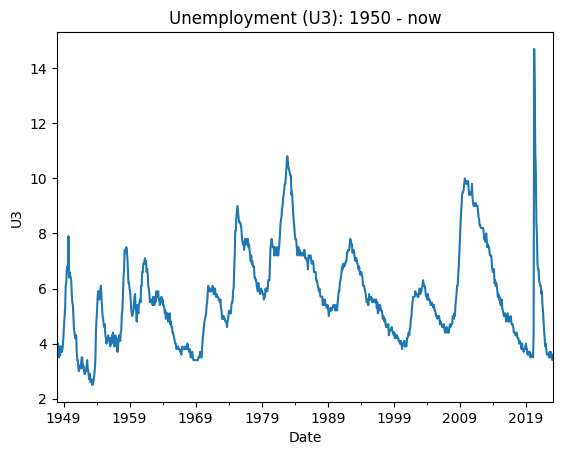

Date
1948-01-31    3.4
1948-02-29    3.8
1948-03-31    4.0
1948-04-30    3.9
1948-05-31    3.5
Freq: M, Name: u3, dtype: float64

In [4]:
#Download series with Fred and resample to end of month data
fred = Fred(api_key='48687714d90448d876bb115d06578128 ')
u3_series = fred.get_series('UNRATE')      
u3_series=u3_series.resample('M').last()
u3_series.index=u3_series.index.rename('Date')
u3_series.name='u3'

#Unemployment Chart
u3_series.plot()
plt.title('Unemployment (U3): 1950 - now')
plt.xlabel('Date')
plt.ylabel('U3')
plt.show()
u3_series.head()

[*********************100%***********************]  1 of 1 completed


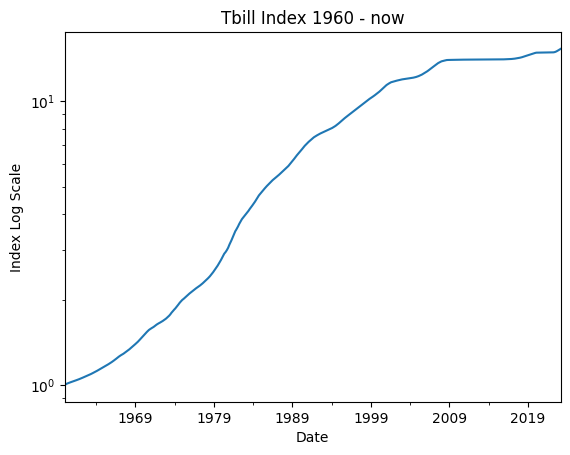

Date
1960-01-31    0.003460
1960-02-29    0.002993
1960-03-31    0.003030
1960-04-30    0.002563
1960-05-31    0.002744
Freq: M, Name: tbill_tr, dtype: float64

In [5]:
#Import Tbill data and calculate monthly returns
start='1950-01-31'
tbill_d=yf.download("^IRX",start)['Adj Close']
tbill_dr=tbill_d/100/252+1
tbill_series=tbill_dr.resample('M').prod()-1
tbill_series.name='tbill_tr'

#Tbill Chart
(tbill_series+1).cumprod().plot(logy=True)
plt.title('Tbill Index 1960 - now')
plt.xlabel('Date')
plt.ylabel('Index Log Scale')
plt.show()
tbill_series.head()

[*********************100%***********************]  1 of 1 completed


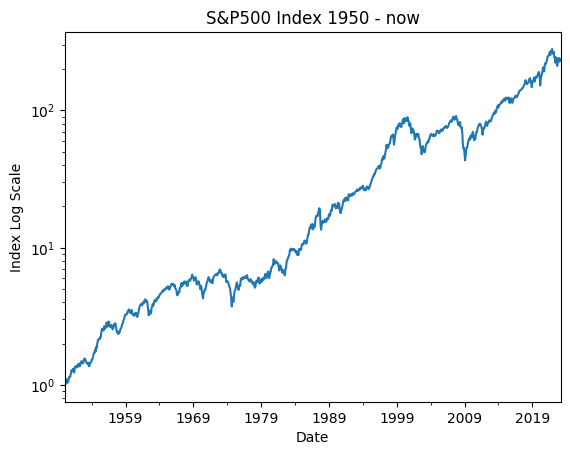

Date
1950-01-31    0.000000
1950-02-28    0.009971
1950-03-31    0.004065
1950-04-30    0.038751
1950-05-31    0.045657
Freq: M, Name: SP500_TR, dtype: float64

In [6]:
#Download S&P500 price data from Yahoo Finance
sp500_series=yf.download("^GSPC","1950-01-31")['Adj Close'].pct_change()+1
sp500_series=sp500_series.resample('M').prod()-1
sp500_series.name='SP500_TR'

#S&P500 Chart
(sp500_series+1).cumprod().plot(logy=True)
plt.title('S&P500 Index 1950 - now')
plt.xlabel('Date')
plt.ylabel('Index Log Scale')
plt.show()
sp500_series.head()

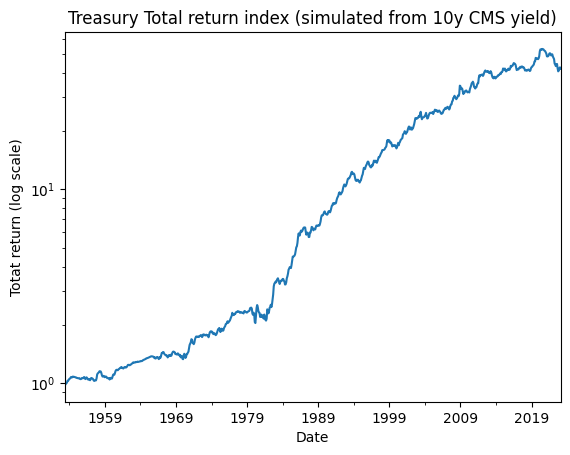

,treasury_yield,yield_chg,dur,treasury_tr
Date,,,,
1953-05-31,0.0305,0.0022,8.767986,-0.016748
1953-06-30,0.0311,0.0006,8.746322,-0.002656
1953-07-31,0.0293,-0.0018,8.811587,0.018303
1953-08-31,0.0295,0.0002,8.804295,0.000697
1953-09-30,0.0287,-0.0008,8.833525,0.009458


In [7]:
#Download Treasury Yield data from NasdaqLink
url_ty='https://data.nasdaq.com/api/v3/datasets/FED/RIFLGFCY10_N_M.csv?api_key=5VHLVjsL1zzxZ77rMAD4'
custom_date_parser=lambda x: dt.datetime.strptime(x,'%Y-%m-%d')
treasury=pd.read_csv(url_ty,index_col='Date',parse_dates=True,date_parser=custom_date_parser)
treasury.sort_index(inplace=True)
treasury=treasury.resample('M').last()
treasury.columns=['treasury_yield']
treasury['treasury_yield']=treasury['treasury_yield']/100

#Calculate a monthly Treasury total return value using yield as coupon and duration function. Should add convexity!
treasury['yield_chg']=treasury['treasury_yield'].diff()
treasury['dur']=duration(treasury['treasury_yield'].values,treasury['treasury_yield'].values,1,10)
treasury['treasury_tr']=treasury['treasury_yield']/12-(treasury['yield_chg']*treasury['dur'])
treasury.dropna(inplace=True)

#Treasury Chart
(treasury['treasury_tr']+1).cumprod().plot(logy=True)
plt.title('Treasury Total return index (simulated from 10y CMS yield)')
plt.ylabel('Totat return (log scale)')
plt.show()
treasury.head()

In [8]:
#Create the final dataframe to work on
strat_df=pd.merge_ordered(treasury['treasury_tr'],sp500_series,how='left',on='Date')
strat_df.set_index('Date',inplace=True)
strat_df.columns=['treasury_tr','sp500_tr']
strat_df=pd.merge_ordered(strat_df,tbill_series,how='right',on='Date')

#Create '60/40 returns
strat_df['bench_tr']=0.6*strat_df['sp500_tr']+0.4*strat_df['treasury_tr']
#Add the economic signal and shift it a month for lag in publication
strat_df=pd.merge_ordered(strat_df,u3_series,how='left',on='Date')
strat_df.set_index('Date',inplace=True)
strat_df=strat_df[:-1]
strat_df['u3']=strat_df['u3'].shift(1)

#Calculate Sahm Rule
strat_df['u3_3mma']=strat_df['u3'].rolling(3).mean()
strat_df['u3_min']=strat_df['u3'].rolling(12).min()
strat_df['recession']=np.where((strat_df['u3']-strat_df['u3_min'])>=0.5,1,0)

#Calculate momentum scores for SP500,Treasuries and Tbills
strat_df['sp500_mom']=mom_score(strat_df['sp500_tr'])
strat_df['treasury_mom']=mom_score(strat_df['treasury_tr'])
strat_df['tbill_mom']=mom_score(strat_df['tbill_tr'])
strat_df.dropna(inplace=True)

In [9]:
#%%script false --no-raise-error

#Built the trading signal based on the Sahm-rule plus momentum and the returns as values
# create a list of our conditions
conditions=[
    (strat_df['recession'].shift(1)==0),
    (strat_df['recession'].shift(1)==1) & (strat_df['sp500_mom'].shift(1)>strat_df['treasury_mom'].shift(1)) &                 
    (strat_df['sp500_mom'].shift(1)>strat_df['tbill_mom'].shift(1)),
    (strat_df['recession'].shift(1)==1) & (strat_df['treasury_mom'].shift(1)>strat_df['sp500_mom'].shift(1)) &                 
    (strat_df['treasury_mom'].shift(1)>strat_df['tbill_mom'].shift(1)),
    (strat_df['recession'].shift(1)==1) & (strat_df['tbill_mom'].shift(1)>strat_df['sp500_mom'].shift(1)) &                 
    (strat_df['tbill_mom'].shift(1)>strat_df['treasury_mom'].shift(1))
    
]


# create a list of the values we want to assign for each condition
values = [strat_df['sp500_tr'],strat_df['sp500_tr'],strat_df['treasury_tr'],strat_df['tbill_tr']]

#Calculate trading signals based on conditions list
trade_signal=[]
for k in range(strat_df.shape[0]):
    month=[conditions[0][k],conditions[1][k],conditions[2][k],conditions[3][k]]
    prev_month=[conditions[0][k-1],conditions[1][k-1],conditions[2][k-1],conditions[3][k-1]]
    if month==prev_month:
        trade_signal.append(0)
    else:
        trade_signal.append(1)
        
strat_df['trade_signal']=trade_signal
strat_df['trade_signal']=strat_df['trade_signal'].shift(-1)
 
# create a new column and use np.select to assign values to it using our lists as arguments
strat_df['strat_tr']=np.select(conditions,values)

#Calculate net returns taking into account transaction cost, based on trading signal
commission=0.002
strat_df['strat_nr']=np.where(strat_df['trade_signal'].shift(2)!=strat_df['trade_signal'].shift(1),strat_df['strat_tr']-commission,strat_df['strat_tr'])

In [10]:
%%script false --no-raise-error

#Built the trading signal based on momentum only and the returns as values 

# create a list of our conditions
conditions=[
    (strat_df['sp500_mom'].shift(1)>strat_df['treasury_mom'].shift(1)) &                                             
    (strat_df['sp500_mom'].shift(1)>strat_df['tbill_mom'].shift(1)),
    (strat_df['treasury_mom'].shift(1)>strat_df['sp500_mom'].shift(1)) &                 
    (strat_df['treasury_mom'].shift(1)>strat_df['tbill_mom'].shift(1)),
    (strat_df['tbill_mom'].shift(1)>strat_df['sp500_mom'].shift(1)) &                 
    (strat_df['tbill_mom'].shift(1)>strat_df['treasury_mom'].shift(1))
    
]


# create a list of the values we want to assign for each condition
values = [strat_df['sp500_tr'],strat_df['treasury_tr'],strat_df['tbill_tr']]

#Calculate trading signals based on conditions list
trade_signal=[]
for k in range(strat_df.shape[0]):
    month=[conditions[0][k],conditions[1][k],conditions[2][k]]
    prev_month=[conditions[0][k-1],conditions[1][k-1],conditions[2][k-1]]
    if month==prev_month:
        trade_signal.append(0)
    else:
        trade_signal.append(1)
        
strat_df['trade_signal']=trade_signal
strat_df['trade_signal']=strat_df['trade_signal'].shift(-1)
 
# create a new column and use np.select to assign values to it using our lists as arguments
strat_df['strat_tr']=np.select(conditions,values)

#Calculate net returns taking into account transaction cost, based on trading signal
commission=0.002
strat_df['strat_nr']=np.where(strat_df['trade_signal'].shift(2)!=strat_df['trade_signal'].shift(1),strat_df['strat_tr']-commission,strat_df['strat_tr'])

In [11]:
#save the strat return series to CSV
strat_return_series=strat_df['strat_nr']
strat_return_series.index.rename('date',inplace=True)
strat_return_series.name='sahm_return'
strat_return_series.to_csv('sahm_return.csv')

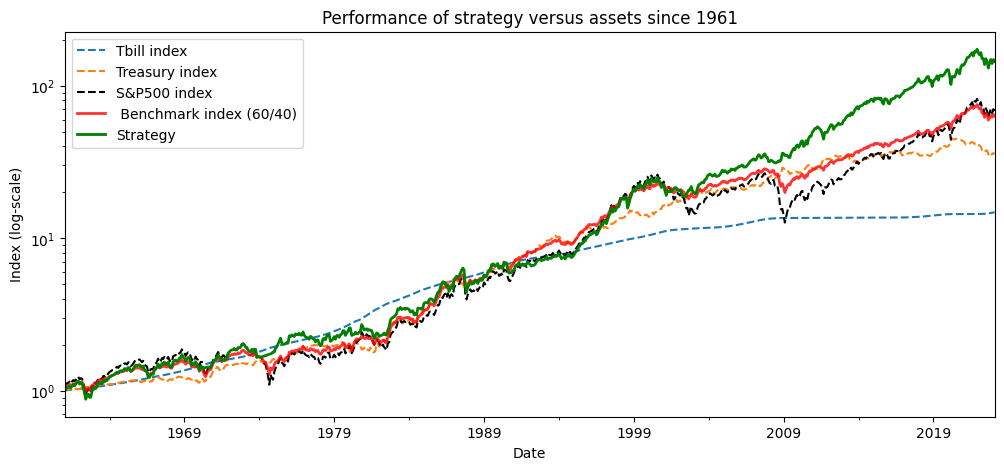

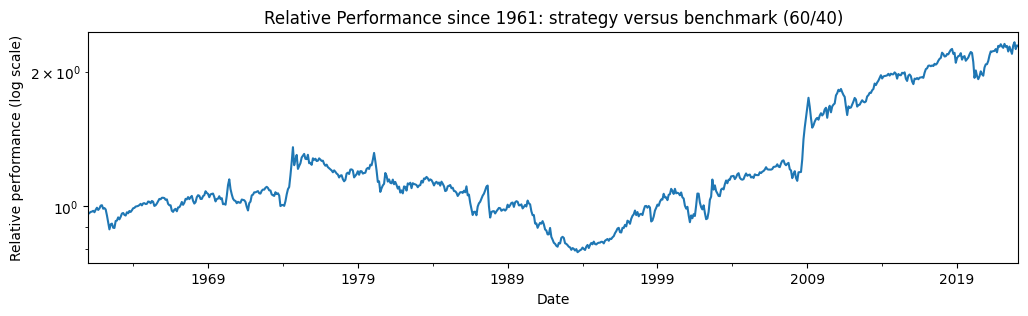

In [12]:
#Build wealth indices for comparison purposes
strat_df['tbill_index']=(strat_df['tbill_tr']+1).cumprod()
strat_df['treasury_index']=(strat_df['treasury_tr']+1).cumprod()
strat_df['sp500_index']=(strat_df['sp500_tr']+1).cumprod()
strat_df['bench_index']=(strat_df['bench_tr']+1).cumprod()
strat_df['strat_index']=(strat_df['strat_nr']+1).cumprod()

#plot the assets and strategy
strat_df['tbill_index'].plot(logy=True,label='Tbill index',figsize=(12,5),linestyle='--')
strat_df['treasury_index'].plot(logy=True,label='Treasury index',linestyle='--')
strat_df['sp500_index'].plot(logy=True,label='S&P500 index',linestyle='--',color='black')
strat_df['bench_index'].plot(logy=True, label=' Benchmark index (60/40)',linewidth=2,color='red',alpha=0.8)
strat_df['strat_index'].plot(logy=True, label='Strategy',linewidth=2,color='green')
plt.title('Performance of strategy versus assets since 1961')
plt.xlabel('Date')
plt.ylabel('Index (log-scale)')
plt.legend()
plt.savefig('strategy_vs_assets.png')
plt.show()


#relative performance
strat_df['relative']=strat_df['strat_index']/strat_df['bench_index']
strat_df['relative'].plot(logy=True,figsize=(12,3))
plt.title('Relative Performance since 1961: strategy versus benchmark (60/40)')
plt.xlabel('Date')
plt.ylabel('Relative performance (log scale)')
plt.savefig('relative performance.png')
plt.show()


In [13]:
#PERFORMANCE METRICS STRATEGY AND BENCHMARK

#correlation between strategy and bench
cor=strat_df["strat_nr"].corr(strat_df['bench_tr'])

#calculate turnover
turnover=strat_df['trade_signal'].mean()

#Annualized Returns
risk_free_ar=annualized_return(strat_df['tbill_tr'],12)
sp500_ar=annualized_return(strat_df['sp500_tr'],12)
treasury_ar=annualized_return(strat_df['treasury_tr'],12)
bench_ar=annualized_return(strat_df['bench_tr'],12)
strat_ar=annualized_return(strat_df['strat_nr'],12)

#Best and worst period returns
strat_best=strat_df['strat_nr'].max()
strat_worst=strat_df['strat_nr'].min()
bench_best=strat_df['bench_tr'].max()
bench_worst=strat_df['bench_tr'].min()
#% profitable
strat_prof=(strat_df['strat_nr']>0).mean()
bench_prof=(strat_df['bench_tr']>0).mean()

#AnnualizedVol
strat_vol=annualized_vol(strat_df['strat_nr'],12)
bench_vol=annualized_vol(strat_df['bench_tr'],12)

#Annualized downside vol
strat_down_vol=downside_vol(strat_df['strat_nr'],12)
bench_down_vol=downside_vol(strat_df['bench_tr'],12)

#Sharpe
strat_sharpe=sharpe_ratio(strat_df['strat_nr'],strat_df['tbill_tr'],12)
bench_sharpe=sharpe_ratio(strat_df['bench_tr'],strat_df['tbill_tr'],12)

#Sortino
strat_sortino=sortino_ratio(strat_df['strat_nr'],strat_df['tbill_tr'],12)
bench_sortino=sortino_ratio(strat_df['bench_tr'],strat_df['tbill_tr'],12)

#Tracking error
strat_tracking_error=tracking_error(strat_df['strat_nr'],strat_df['bench_tr'],12)

#InformationRatio
strat_info_ratio=information_ratio(strat_df['strat_nr'],strat_df['bench_tr'],12)
#information_ratio=(strat_ar-bench_ar)/strat_tracking_error 

#skew of strategy and benchmark
strat_skew=ss.skew(strat_df['strat_nr'])
bench_skew=ss.skew(strat_df['bench_tr'])

#Excess kurtosis of strategy and benchmark
strat_kurt=ss.kurtosis(strat_df['strat_nr'])
bench_kurt=ss.kurtosis(strat_df['bench_tr'])

#Var of strategy and benchmark

strat_var99=np.quantile(strat_df['strat_nr'],q=0.01)
bench_var99=np.quantile(strat_df['bench_tr'],q=0.01)

#CVAR of strategy and benchmark
strat_cvar99=strat_df['strat_nr'][strat_df['strat_nr']<strat_var99].mean()
bench_cvar99=strat_df['bench_tr'][strat_df['bench_tr']<bench_var99].mean()

#Parametric Gaussian VAR
strat_pvar99=strat_ar+ss.norm.ppf(0.01)*strat_vol
bench_pvar99=bench_ar+ss.norm.ppf(0.01)*bench_vol

#Drawdowns Strategy
strat_max=strat_df['strat_index'].cummax()
strat_dd=strat_df['strat_index']/strat_max-1
#Drawdowns Bench
bench_max=strat_df['bench_index'].cummax()
bench_dd=strat_df['bench_index']/bench_max-1
#MaxDrawdown
strat_md=min(strat_dd)
bench_md=min(bench_dd)
#MAR since inception
strat_r_to_md=strat_ar/abs(strat_md)
bench_r_to_md=bench_ar/abs(bench_md)

In [14]:
#Put Everything in DataFrame
output_dict={'Performance Metrics':['Correlation with benchmark','CAGR%','Best month','Worst month','% profitable','Vol','Downside Vol','Sharpe Ratio','Sortino Ratio','Information Ratio','Tracking Error','Skewness','Excess Kurtosis','Historic Var (1%)','Historic Cvar (1%)','Gaussian Var (1%)','Max Drawdown %','MAR ratio','Average Turnover per Year'],
        'Strategy':['{:.2f}%'.format(cor*100),'{:.2f}%'.format(strat_ar*100),'{:.2f}%'.format(strat_best*100),'{:.2f}%'.format(strat_worst*100),'{:.2f}%'.format(strat_prof*100),'{:.2f}%'.format(strat_vol*100),'{:.2f}%'.format(strat_down_vol*100),'{:.2f}'.format(strat_sharpe),'{:.2f}'.format(strat_sortino),'{:.2f}'.format(strat_info_ratio),'{:.2f}%'.format(strat_tracking_error*100),'{:.2f}'.format(strat_skew),'{:.2f}'.format(strat_kurt),'{:.2f}%'.format(strat_var99*100),'{:.2f}%'.format(strat_cvar99*100),'{:.2f}%'.format(strat_pvar99*100),'{:.2f}%'.format(strat_md*100),'{:.2f}'.format(strat_r_to_md),'{:.2f}%'.format(turnover*100*12)],
        'Benchmark 60/40':['-','{:.2f}%'.format(bench_ar*100),'{:.2f}%'.format(bench_best*100),'{:.2f}%'.format(bench_worst*100),'{:.2f}%'.format(bench_prof*100),'{:.2f}%'.format(bench_vol*100),'{:.2f}%'.format(bench_down_vol*100),'{:.2f}'.format(bench_sharpe),'{:.2f}'.format(bench_sortino),'-','-','{:.2f}'.format(bench_skew),'{:.2f}'.format(bench_kurt),'{:.2f}%'.format(bench_var99*100),'{:.2f}%'.format(bench_cvar99*100),'{:.2f}%'.format(bench_pvar99*100),'{:.2f}%'.format(bench_md*100),'{:.2f}'.format(bench_r_to_md),'{:.2f}%'.format(0)]}

start=strat_df.index[0].strftime("%Y-%m")
end = strat_df.index[-1].strftime("%Y-%m")

metrics=pd.DataFrame(output_dict)
metrics=metrics.rename(columns={'Performance Metrics':'Performance Metrics '+'( '+start+' till '+end+ ')'})
metrics




,Performance Metrics ( 1961-01 till 2023-02),Strategy,Benchmark 60/40
0,Correlation with benchmark,84.26%,-
1,CAGR%,8.32%,6.87%
2,Best month,13.18%,10.74%
3,Worst month,-21.76%,-13.02%
4,% profitable,62.20%,61.26%
5,Vol,13.26%,9.75%
6,Downside Vol,9.61%,6.58%
7,Sharpe Ratio,0.30,0.26
8,Sortino Ratio,0.42,0.39
9,Information Ratio,0.20,-


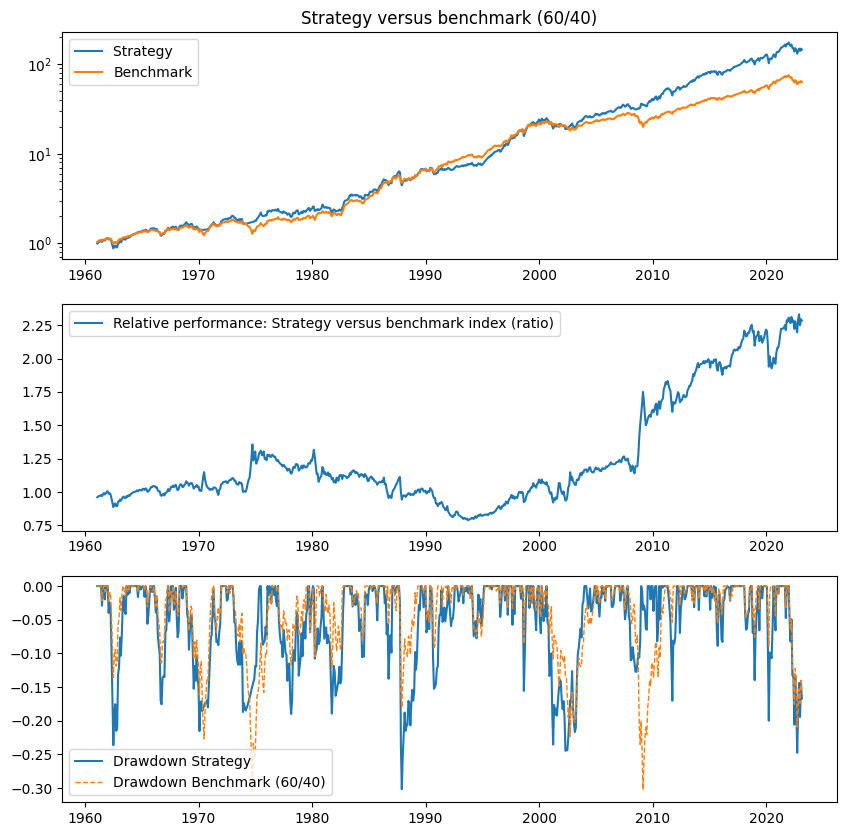

In [15]:
fig,ax=plt.subplots(3,1,figsize=(10,10))
ax[0].set_title("Strategy versus benchmark (60/40)")
ax[0].semilogy(strat_df['strat_index'],label="Strategy ")
ax[0].semilogy(strat_df['bench_index'],label="Benchmark")
ax[0].legend()
ax[1].plot(strat_df['relative'],label="Relative performance: Strategy versus benchmark index (ratio)")
ax[1].legend()
ax[2].plot(strat_dd,label='Drawdown Strategy')
ax[2].plot(bench_dd,label='Drawdown Benchmark (60/40)',linestyle='--',linewidth=1)
ax[2].legend()
plt.savefig('strategy_and_benchmark.png')
plt.show()

In [16]:
strat_df['year']=strat_df.index.year
strat_df['month']=strat_df.index.month

#create a pivot table of the strategy with strategy returns as values, years as rows and columns as as month values
strat_pivot = strat_df.pivot(values='strat_nr',index='year',columns='month')
#rename the columns labels with month names
months = ['Jan','Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec']
strat_pivot.rename(columns=dict(enumerate(months,1)),inplace=True)
#Add a column that contains the total return for each year
strat_pivot['total']=(strat_pivot+1).prod(axis=1)-1
#get normal monhtly returns 
strat_pivot=(strat_pivot*100)

#style the ivot tbae
return_df=style_df(strat_pivot)
return_df

month,Jan,Feb,March,April,May,June,July,Aug,Sep,Oct,Nov,Dec,total
year,,,,,,,,,,,,,
1961,-0.20%,2.49%,2.35%,0.38%,1.91%,-2.88%,3.28%,1.96%,-1.97%,2.83%,3.93%,0.12%,14.90%
1962,-3.99%,1.63%,-0.59%,-6.20%,-8.60%,-8.18%,6.36%,1.53%,-4.82%,0.44%,10.16%,1.35%,-11.99%
1963,4.91%,-2.89%,3.55%,4.65%,1.43%,-2.22%,-0.55%,4.87%,-1.30%,3.22%,-1.05%,2.44%,17.94%
1964,2.69%,0.99%,1.52%,0.61%,1.15%,1.64%,1.82%,-1.62%,2.87%,0.81%,-0.52%,0.39%,12.97%
1965,3.32%,-0.15%,-1.45%,3.42%,-0.77%,-4.86%,1.34%,2.25%,3.20%,2.73%,-0.88%,0.90%,9.06%
1966,0.49%,-1.79%,-2.18%,2.05%,-5.41%,-1.61%,-1.35%,-7.78%,-0.70%,4.75%,0.31%,-0.15%,-13.09%
1967,7.82%,0.20%,3.94%,4.22%,-5.24%,1.75%,4.53%,-1.17%,3.28%,-3.53%,0.75%,2.63%,20.09%
1968,-4.38%,-3.12%,0.94%,8.05%,1.25%,0.91%,-1.85%,1.15%,3.85%,0.72%,4.80%,-4.16%,7.66%
1969,-0.82%,-4.74%,3.44%,2.15%,-0.22%,-5.56%,-6.02%,4.01%,-2.50%,4.30%,-3.41%,-1.87%,-11.36%


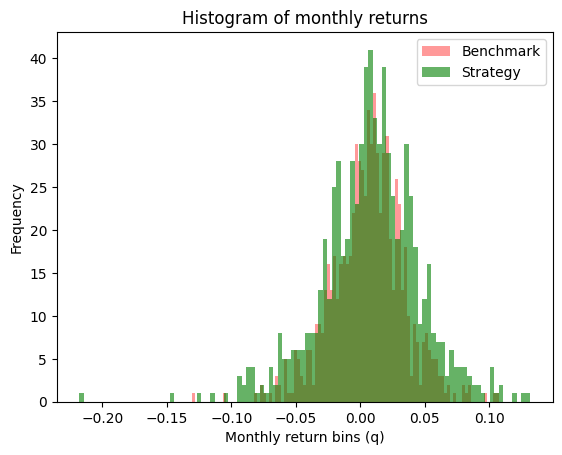

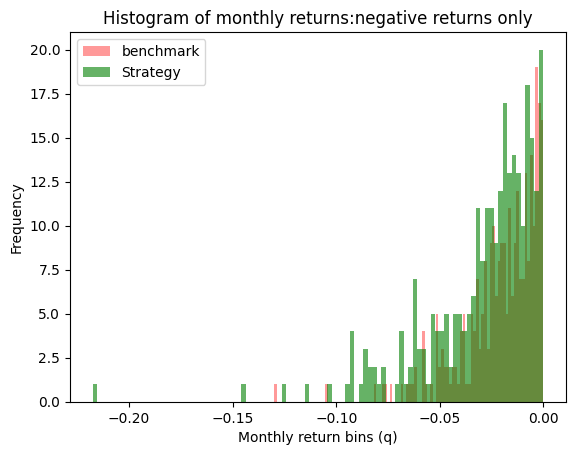

NameError: name 'emp' is not defined

In [17]:
#Histogram of returns Bench and Strat
plt.hist(strat_df['bench_tr'].dropna(),bins=100,histtype='stepfilled',alpha=0.4,label='Benchmark',color='red')
plt.hist(strat_df['strat_nr'].dropna(),bins=100,histtype='stepfilled',alpha=0.6,color='green',label='Strategy')
plt.title('Histogram of monthly returns')
plt.xlabel('Monthly return bins (q)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Histogram of negative returns Bench and Strat
plt.hist(strat_df[strat_df['bench_tr']<0]['bench_tr'].dropna(),bins=100,histtype='stepfilled',alpha=0.4,label='benchmark',color='red')
plt.hist(strat_df[strat_df['strat_nr']<0]['strat_nr'].dropna(),bins=100,histtype='stepfilled',alpha=0.6,color='green',label='Strategy')
plt.title('Histogram of monthly returns:negative returns only')
plt.xlabel('Monthly return bins (q)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('histogram_returns')
plt.show()

#Cumulative Distribution Function of  returns Bench and Strat
strat_cdf=emp.Cdf.from_seq(strat_df['strat_nr'].dropna())
bench_cdf=emp.Cdf.from_seq(strat_df['bench_tr'].dropna())
plt.plot(strat_cdf,color='green',label='strategy')
plt.plot(bench_cdf,color='blue',label='benchmark')
plt.title("Cumulative distribution function")
plt.xlabel('monthly returns (q)')
plt.ylabel('probability (p) of monhtly return < q')
plt.legend()
plt.savefig('cdf_returns')
plt.show()

print('Benchmark: % of monthly returns below 0% is {:.2f}%'.format(bench_cdf(0)*100))
print('Strategy: % of monhtly returns below 0% is {:.2f}%'.format(strat_cdf(0)*100))

#Kernel Distribution Estimate of strategy and benchmark
sns.kdeplot(strat_df['strat_nr'].dropna(),label='Strategy',color='green')
sns.kdeplot(strat_df['bench_tr'].dropna(),label='Benchmark',color='blue')
x=np.linspace(-0.3,0.3)
y=ss.norm(0.02,0.03).pdf(x)
plt.plot(x,y,label= 'normal distribution',color='red',linestyle='--',alpha=0.6)
plt.title("Kernel density estimate")
plt.xlabel('Monthly returns')
plt.ylabel('Density')
plt.legend()
plt.savefig('kernel')
plt.show()

In [33]:

#Explore relationship between benchmark returns and strategy returns
plt.plot(strat_df['bench_tr'],strat_df['strat_nr'],'o',alpha=0.2,markersize=3)
plt.title('relationship between returns benchmark and strategy')
plt.xlabel('returns benchmark 60/40')
plt.ylabel('returns strategy')
plt.axis([-0.25,0.2,-0.25,0.2])

#correlation matrix of returns different assets
strat_df[['strat_nr','bench_tr','sp500_tr','treasury_tr','tbill_tr']].corr()

#simple regression
res=ss.linregress(strat_df['bench_tr'],strat_df['strat_nr'])
print(res)
res.slope




In [19]:
strat_df